# Efficiently sampling mixture models

_Boris Leistedt, April 2017_

_with valuable comments from X_

This notebook is available at [this location on Github](https://github.com/ixkael/Prob-tools/blob/master/notebooks/Efficiently%20sampling%20mixture%20models.ipynb). 

In this notebook we will consider the problem of efficiently inferring the parameters of mixture models. We will touch upon the following topics:
- a first example of mixture models: density modelling with Gaussian mixtures
- parameter inference via an Ensemble sampler (emcee)
- parameter inference via Hamiltonian Monte Carlo (HMC) with automatic differentiation
- a second example of mixture model: regression with multiple populations
- multimodality of the posterior distribution, and how standard HMC fails
- a more robust inference scheme: hybrid Gibbs - Hamiltonian Monte Carlo

### Requirements

Some basic knowledge of Bayes theorem, parameter inference via MCMC, and hierarchical probabilistic models.

You will need `matplotlib`, `scipy`, `numpy`, `autograd`,
and `daft` if you want to draw the graphical model.

In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = 'retina'
%config InlineBackend.figure_format = 'retina'

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
from cycler import cycler

import emcee
import corner

import autograd.numpy as np
from autograd.scipy.misc import logsumexp
from autograd import grad, hessian
import numpy as onp
from scipy.optimize import minimize
from scipy.misc import derivative

import daft

rc("font", family="serif", size=14)
rc("text", usetex=True)
matplotlib.rcParams['lines.linewidth'] = 2
matplotlib.rcParams['patch.linewidth'] = 2
matplotlib.rcParams['axes.prop_cycle'] =\
    cycler("color", ['k', 'c', 'm', 'y'])
matplotlib.rcParams['axes.labelsize'] = 16

## What are mixture models?

## Density modeling with Gaussian Mixtures

Let's make a simulation. The parameters of this model are fixed (as opposed to randomly drawn) in order to stabilize the results below. This is also because inference with Gaussian mixtures can quickly escalate, as we will discuss below.

In [2]:
# This is a function to convert N-1 variables in [0, 1] onto the simplex,
# i.e. N variables that are positive and sum to one.
# This follows Betancourt (2010) https://arxiv.org/abs/1010.3436
# and we will discuss this reparametrization extensively below.
# At this stage, please ignore, ans assume that we are simply drawing
# the relative amplitudes of the mixture components.
def zs_to_alphas(zs):
    fac = np.concatenate((1 - zs, np.array([1])))
    zsb = np.concatenate((np.array([1]), zs))
    fs = np.cumprod(zsb) * fac
    return fs

nobj = 200 
nt = 2
zs = np.array([0.3])
alphas = zs_to_alphas(zs)
betas = np.array([0.4, 0.6])
betas.sort()
gammas = np.array([0.06, 0.06])
typecounts = np.random.multinomial(nobj, alphas)
types = np.concatenate([np.repeat(i, ni) for i, ni in enumerate(typecounts)]).astype(int)
xis = betas[types] + gammas[types] * np.random.randn(nobj) # Gaussian draws 
xis = np.array([betas[t] + gammas[t] * np.random.randn() for t in types]) # Gaussian draws 
sigmais = np.random.uniform(0.05, 0.15, size=nobj) 
yis = xis + sigmais * np.random.randn(nobj)  # Gaussian draws from N(x_i, sigma_i)
x_grid = np.linspace(0, 1, 100)
p_x_grid = alphas[None, :] * np.exp(-0.5*((x_grid[:, None] - betas[None, :])/gammas[None, :])**2)/\
    np.sqrt(2*np.pi)/gammas[None, :]

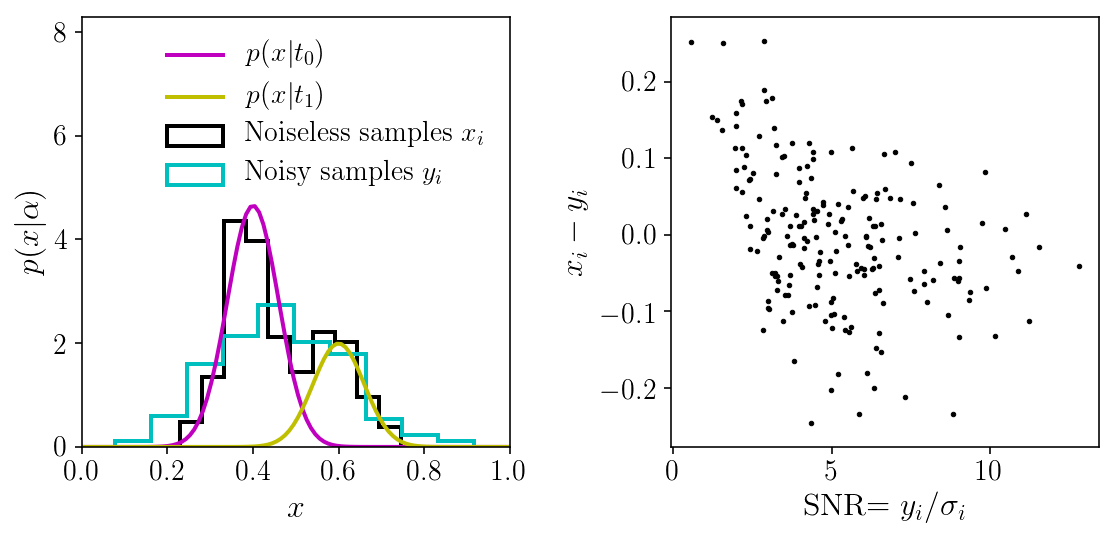

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].hist(xis, histtype='step', normed=True,
           label=r'Noiseless samples $x_i$')
axs[0].hist(yis, histtype='step', normed=True,
           label=r'Noisy samples $y_i$')
for t in range(nt):
    axs[0].plot(x_grid, p_x_grid[:, t], label=r'$p(x | t_'+str(t)+')$')
axs[0].legend(frameon=True).get_frame().set_linewidth(0)
axs[0].set_xlim([0, 1])
axs[0].set_ylim([0, axs[0].get_ylim()[1]*1.7])
axs[0].set_ylabel(r'$p(x|\alpha)$')
axs[0].set_xlabel(r'$x$')
axs[1].scatter(yis/sigmais, xis-yis, lw=0.5, s=5)
axs[1].set_xlabel(r'SNR$=y_i/\sigma_i$')
axs[1].set_ylabel(r'$x_i-y_i$')
fig.tight_layout()

As we can see, our noisy samples span a wider domain than the initial density. Because of the noise, the density is blurried, and we cannot resolve the two components. In fact, we barely guess that there are two components. But, as we will see below, because the noise is known, is can be deconvolved, and we can recover the two components pretty well.

Let us now write the posterior distribution of the parameters of this model.

In [ ]:
equations of the posterior distributions

without and with marginalization

In [4]:
# Let's first define a few basic functions we will need.

def gaussian(x, mu, sig):
    return np.exp(-0.5*((x - mu)/sig)**2) / np.sqrt(2*np.pi) / sig

def gaussian_gradmu(x, mu, sig):
    return - gaussian(x, mu, sig) * (x - mu)/sig**2

def gaussian_gradsig(x, mu, sig):
    return - gaussian(x, mu, sig) / sig + gaussian(x, mu, sig) * (x - mu)**2/sig**3

def gaussiansumsig(x, mu, sig1, sig2):
    sig = np.sqrt(sig1**2 + sig2**2)
    return gaussian(x, mu, sig)
    
def gaussiansumsig_gradsig1(x, mu, sig1, sig2):
    sig = np.sqrt(sig1**2 + sig2**2)
    return gaussian_gradsig(x, mu, sig) * sig1 / sig

def lngaussian(x, mu, sig):
    return - 0.5*((x - mu)/sig)**2 - 0.5*np.log(2*np.pi) - np.log(sig)

def lngaussian_gradmu(x, mu, sig):
    return (x - mu) / sig**2

def lngaussian_gradsig(x, mu, sig):
    return (x - mu)**2 / sig**3 - 1. / sig 
    
# Let's also define a convenient function for testing gradients and derivatives.
# We compare the analytic prediction to the numerical derivative.
def test_derivative(x0, fun, fun_grad, relative_accuracy, n=1, lim=0, order=9, dxfac=0.01,
                    verbose=False, superverbose=False):
    grads = fun_grad(x0)
    for i in range(x0.size):
        if verbose:
            print(i, end=" ")
        def f(v):
            x = 1*x0
            x[i] = v
            return fun(x)
        grads2 = derivative(f, x0[i], dx=dxfac*x0[i], order=order, n=n)
        if superverbose:
            print(i, grads2, grads[i])
        if np.abs(grads2) >= lim:
            onp.testing.assert_allclose(grads2, grads[i],
                                       rtol=relative_accuracy)

relative_accuracy = 0.0001
x = np.array([0.1])
mu = np.array([0.2])
sig1 = np.array([0.3])
sig2 = np.array([0.0])

def fun(sig1):
    return lngaussian(x, mu, sig1)
def fun_grad(sig1):
    return lngaussian_gradsig(x, mu, sig1)

test_derivative(sig1, fun, fun_grad, relative_accuracy)  # It will complain if the gradients are wrong.

In [5]:
# The full posterior distribution is easy to code up:
def lnprob_hyperonly(params):
    alphas, betas, gammas = params[0:nt], params[nt:2*nt], params[2*nt:3*nt]
    likes = np.log(alphas[None, :]) + lngaussian(yis[:, None], betas[None, :], 
                                      np.sqrt(gammas[None, :]**2. + sigmais[:, None]**2.))
    return - np.sum(logsumexp(likes, axis=1))

In [ ]:
show degeneracy of alphas with emcee?

In [21]:
def lnprob(params):
    zs, betas, gammas = params[0:nt-1], params[nt-1:2*nt-1], params[2*nt-1:3*nt-1]
    for i in range(nt-1):
        if betas[i] >= betas[i+1]:
            return -np.inf
    if np.any(params <= 0.01) or np.any(params >= 0.99):
        return -np.inf
    return -lnprob_hyperonly(params)

params = np.concatenate([zs, betas, gammas])
ndim = params.size
nwalkers = ndim * 20
p0s = [params*np.random.uniform(0.8, 1.2, ndim) for i in range(nwalkers)]
for p0 in p0s:
    p0[nt-1:2*nt-1].sort()
    p0[p0 < 0.01] = 0.01
    p0[p0 > 0.99] = 0.99
    if ~np.isfinite(lnprob(p0)):
        print(p0)
        stop

print(lnprob(p0s[0]))
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)
pos, prob, state = sampler.run_mcmc(p0s, 400)
sampler.reset()
_ = sampler.run_mcmc(pos, 400)

93.8534294879


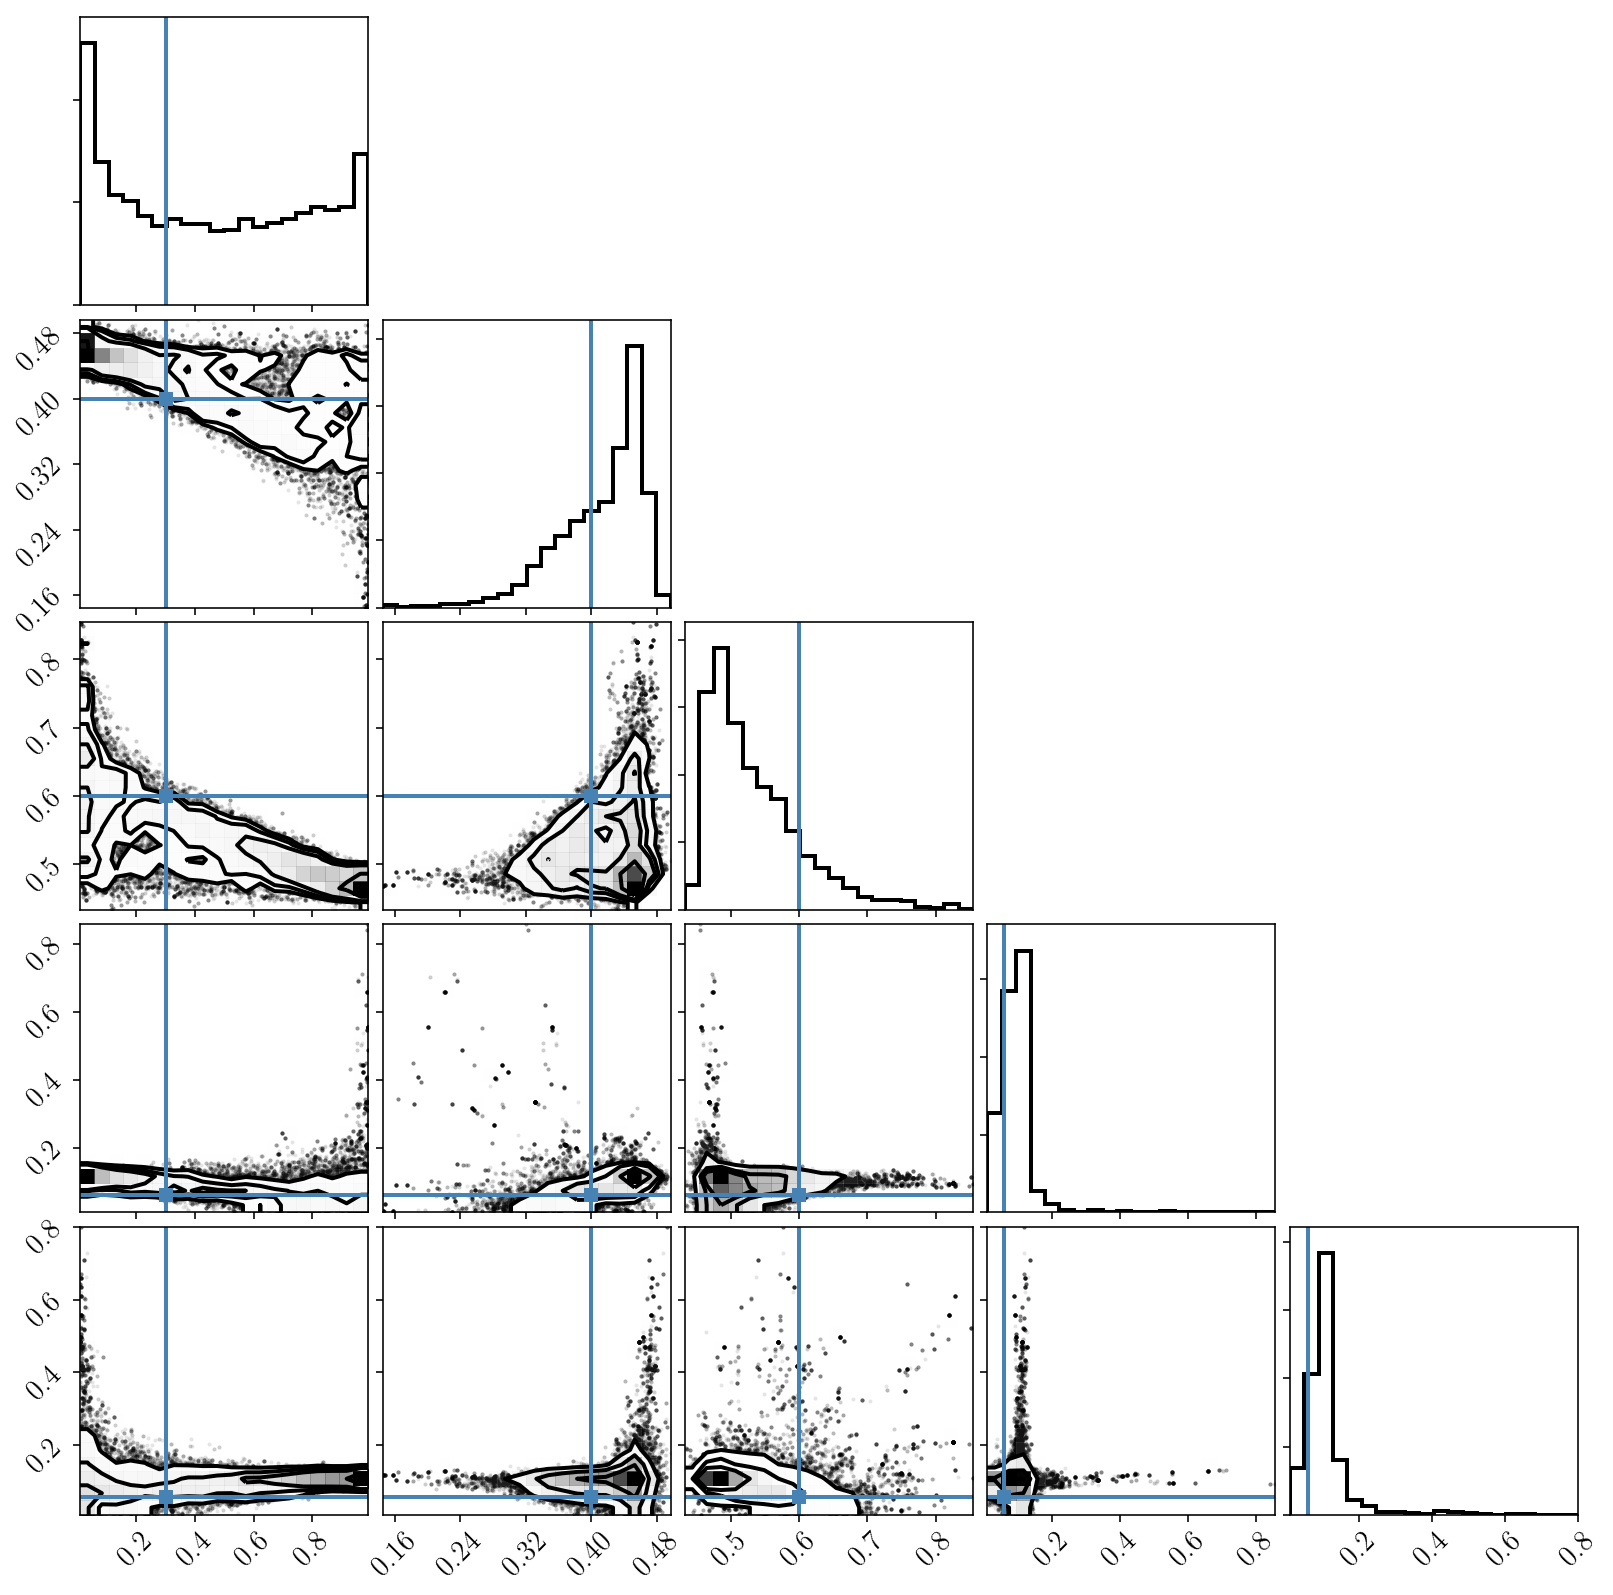

In [22]:
_ = corner.corner(sampler.flatchain, truths=params)

In [9]:
# For HMC, we need the gradients!

#We also need to reparametrize the simplex...

lnprob_hyperonly_grad = grad(lnprob_hyperonly)

params = np.concatenate([alphas, betas, gammas])

def fun(params):
    return lnprob_hyperonly(params)
def fun_grad(params):
    return lnprob_hyperonly_grad(params)

relative_accuracy = 0.00001
test_derivative(params, fun, fun_grad, relative_accuracy)

In [10]:
def alphaszs_jacobian(fs, zs):
    jaco = np.zeros((zs.size, fs.size))
    for j in range(fs.size):
        for i in range(zs.size):
            if i < j:
                jaco[i, j] = fs[j] / zs[i]
            if i == j:
                jaco[i, j] = fs[j] / (zs[j] - 1)
    return jaco

def sublnprob_hyperonly(params):
    alphas, betas, gammas = params[0:nt], params[nt:2*nt], params[2*nt:3*nt]
    xis = params[3*nt:3*nt+nobj]
    lnlikes = np.log(alphas[None, :]) + lngaussian(yis[:, None], betas[None, :], 
                                      np.sqrt(gammas[None, :]**2. + sigmais[:, None]**2.))
    res = - np.sum(logsumexp(lnlikes, axis=1))
    if ~np.isfinite(res):
        print("Infinite likelihood call with", params)
    return res

def lnprob_hyperonly(params):
    zs, betas, gammas = params[0:nt-1], params[nt-1:2*nt-1], params[2*nt-1:3*nt-1]
    alphas = zs_to_alphas(zs)
    res = sublnprob_hyperonly(np.concatenate([alphas, params[nt-1:]]))
    return res

sublnprob_hyperonly_grad = grad(sublnprob_hyperonly)
sublnprob_hyperonly_hessian = hessian(sublnprob_hyperonly)

def lnprob_hyperonly_grad(params):
    zs, betas, gammas = params[0:nt-1], params[nt-1:2*nt-1], params[2*nt-1:3*nt-1]
    alphas = zs_to_alphas(zs)
    jac = alphaszs_jacobian(alphas, zs)
    subgrads = sublnprob_hyperonly_grad(np.concatenate([alphas, params[nt-1:]]))
    grads = 1*subgrads[1:]
    grads[0:nt-1] = np.dot(jac, subgrads[0:nt])
    if np.any(~np.isfinite(grads)):
        print("Infinite likelihood gradient call with", params)
    return grads


def lnprob_hyperonly_hessian(params):
    zs, betas, gammas = params[0:nt-1], params[nt-1:2*nt-1], params[2*nt-1:3*nt-1]
    alphas = zs_to_alphas(zs)
    jac = alphaszs_jacobian(alphas, zs)
    subhess = sublnprob_hyperonly_hessian(np.concatenate([alphas, params[nt-1:]]))
    subhessdiag = np.diag(subhess)
    hess = 1*subhessdiag[1:]
    hess[0:nt-1] = np.diag(np.dot(np.dot(jac, subhess[0:nt, 0:nt]), jac.T))
    if np.any(~np.isfinite(hess)):
        print("Infinite likelihood hessian call with", params)
    return hess


params = np.concatenate([zs, betas, gammas])
print(lnprob_hyperonly(params), lnprob_hyperonly_grad(params), lnprob_hyperonly_hessian(params))

def fun(params):
    return lnprob_hyperonly(params)
def fun_grad(params):
    return lnprob_hyperonly_grad(params)

relative_accuracy = 0.0001
test_derivative(params, fun, fun_grad, relative_accuracy, superverbose=False)

def fun_hess(params):
    return lnprob_hyperonly_hessian(params)

relative_accuracy = 0.001
test_derivative(params, fun, fun_hess, relative_accuracy, superverbose=False, n=2)

-100.667807464 [-12.35444976 -36.87501324  21.97240775 -84.31093737  24.08866122] [  419.92339726  8035.01724254  3280.88651321  6792.08688817  1922.18271395]


In [110]:
# This is the function that performs one HMC sample, 
# with num_steps steps of size step_size relative to the gradient.
# x0 is the initial point, lnprob the posterior distribution, lnprobgrad is gradients.
def hmc_sampler(x0, lnprob, lnprobgrad, step_size,
                num_steps, inv_mass_matrix_diag=None, bounds=None, kwargs={}):
    if bounds is None:
        bounds = np.zeros((x0.size, 2))
        bounds[:, 0] = 0.001
        bounds[:, 1] = 0.999
    if inv_mass_matrix_diag is None: 
        inv_mass_matrix_diag = np.repeat(1, x0.size)
        inv_mass_matrix_diag_sqrt = np.repeat(1, x0.size)
    else:
        assert inv_mass_matrix_diag.size == x0.size
        inv_mass_matrix_diag_sqrt = inv_mass_matrix_diag**0.5
    v0 = np.random.randn(x0.size) / inv_mass_matrix_diag_sqrt
    v = v0 - 0.5 * step_size * lnprobgrad(x0, **kwargs)
    x = x0 + step_size * v * inv_mass_matrix_diag
    ind_upper = x > bounds[:, 1]
    x[ind_upper] = 2*bounds[ind_upper, 1] - x[ind_upper]
    v[ind_upper] = - v[ind_upper]
    ind_lower = x < bounds[:, 0]
    x[ind_lower] = 2*bounds[ind_lower, 0] - x[ind_lower]
    v[ind_lower] = - v[ind_lower]
    ind_upper = x > bounds[:, 1]
    ind_lower = x < bounds[:, 0]
    ind_bad = np.logical_or(ind_lower, ind_upper)
    if ind_bad.sum() > 0:
        print('Error: could not confine samples within bounds!')
        print('Number of problematic parameters:', ind_bad.sum(), 'out of', ind_bad.size)
        return x0
                
    for i in range(num_steps):
        v = v - step_size * lnprobgrad(x, **kwargs)
        x = x + step_size * v * inv_mass_matrix_diag
        ind_upper = x > bounds[:, 1]
        x[ind_upper] = 2*bounds[ind_upper, 1] - x[ind_upper]
        v[ind_upper] = - v[ind_upper]
        ind_lower = x < bounds[:, 0]
        x[ind_lower] = 2*bounds[ind_lower, 0] - x[ind_lower]
        v[ind_lower] = - v[ind_lower]
        ind_upper = x > bounds[:, 1]
        ind_lower = x < bounds[:, 0]
        ind_bad = np.logical_or(ind_lower, ind_upper)
        if ind_bad.sum() > 0:
            print('Error: could not confine samples within bounds!')
            print('Number of problematic parameters:', ind_bad.sum(), 'out of', ind_bad.size)
            return x0

    v = v - 0.5 * step_size * lnprobgrad(x, **kwargs)
    orig = lnprob(x0, **kwargs)
    current = lnprob(x, **kwargs)
    if inv_mass_matrix_diag is None:
        orig += 0.5 * np.dot(v0.T, v0)
        current += 0.5 * np.dot(v.T, v)
    else:
        orig += 0.5 * np.sum(inv_mass_matrix_diag * v0**2.)
        current += 0.5 * np.sum(inv_mass_matrix_diag * v**2.)
        
    p_accept = min(1.0, np.exp(orig - current))
    if(np.any(~np.isfinite(x))):
        print('Error: some parameters are infinite!', np.sum(~np.isfinite(x)), 'out of', x.size)
        print('HMC steps and stepsize:', num_steps, step_size)
        return x0
    if p_accept > np.random.uniform():
        return x
    else:
        if p_accept < 0.01:
            print('Error: acceptance rate is very small! It is', p_accept)
            print('HMC steps and stepsize:', num_steps, step_size)
            #stop
        return x0

In [12]:
num_samples, burnin = 5000, 500

params = np.concatenate([zs, betas, gammas])
bounds = np.zeros((params.size, 2))
bounds[:, 0] = 0.01
bounds[:, 1] = 0.99
param_samples_hyperonly = np.zeros((num_samples, params.size))
param_samples_hyperonly[0, :] = params 

if False:
    res = minimize(lnprob_hyperonly2, params,
             jac=lnprob_hyperonly2_grad)
    print(res)
    param_samples_hyperonly[0, :] = res.x

    hess = np.zeros((params.size, ))
    dxfac = 0.01
    order = 15
    for i in range(params.size):
        def f(v):
            x = 1*res.x
            x[i] = v
            return lnprob_hyperonly2(x)
        hess[i] = derivative(f, res.x[i], dx=dxfac*res.x[i], order=order, n=2)
  
hess = np.abs(lnprob_hyperonly_hessian(params))
for i in range(1, num_samples):
    print(i, end=" ")
    step_size = np.random.uniform(1e-3, 1e-1)
    num_steps = np.random.randint(2, 10)
    if i % 500 == 0:
        newparams = np.mean(param_samples_hyperonly[0:i-1, :], axis=0)
        hess = np.abs(lnprob_hyperonly_hessian(newparams))
    param_samples_hyperonly[i, :] =\
        hmc_sampler(param_samples_hyperonly[i-1, :],
                    lnprob_hyperonly, lnprob_hyperonly_grad,
                    step_size, num_steps,
                    bounds=bounds, inv_mass_matrix_diag=1./hess)
param_samples_hyperonly = param_samples_hyperonly[burnin:, :]

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 

1877 1878 1879 1880 1881 1882 1883 1884 1885 1886 1887 1888 1889 1890 1891 1892 1893 1894 1895 1896 1897 1898 1899 1900 1901 1902 1903 1904 1905 1906 1907 1908 1909 1910 1911 1912 1913 1914 1915 1916 1917 1918 1919 1920 1921 1922 1923 1924 1925 1926 1927 1928 1929 1930 1931 1932 1933 1934 1935 1936 1937 1938 1939 1940 1941 1942 1943 1944 1945 1946 1947 1948 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067 2068 2069 2070 2071 2072 2073 2074 2075 2076 

3519 3520 3521 3522 3523 3524 3525 3526 3527 3528 3529 3530 3531 3532 3533 3534 3535 3536 3537 3538 3539 3540 3541 3542 3543 3544 3545 3546 3547 3548 3549 3550 3551 3552 3553 3554 3555 3556 3557 3558 3559 3560 3561 3562 3563 3564 3565 3566 3567 3568 3569 3570 3571 3572 3573 3574 3575 3576 3577 3578 3579 3580 3581 3582 3583 3584 3585 3586 3587 3588 3589 3590 3591 3592 3593 3594 3595 3596 3597 3598 3599 3600 3601 3602 3603 3604 3605 3606 3607 3608 3609 3610 3611 3612 3613 3614 3615 3616 3617 3618 3619 3620 3621 3622 3623 3624 3625 3626 3627 3628 3629 3630 3631 3632 3633 3634 3635 3636 3637 3638 3639 3640 3641 3642 3643 3644 3645 3646 3647 3648 3649 3650 3651 3652 3653 3654 3655 3656 3657 3658 3659 3660 3661 3662 3663 3664 3665 3666 3667 3668 3669 3670 3671 3672 3673 3674 3675 3676 3677 3678 3679 3680 3681 3682 3683 3684 3685 3686 3687 3688 3689 3690 3691 3692 3693 3694 3695 3696 3697 3698 3699 3700 3701 3702 3703 3704 3705 3706 3707 3708 3709 3710 3711 3712 3713 3714 3715 3716 3717 3718 

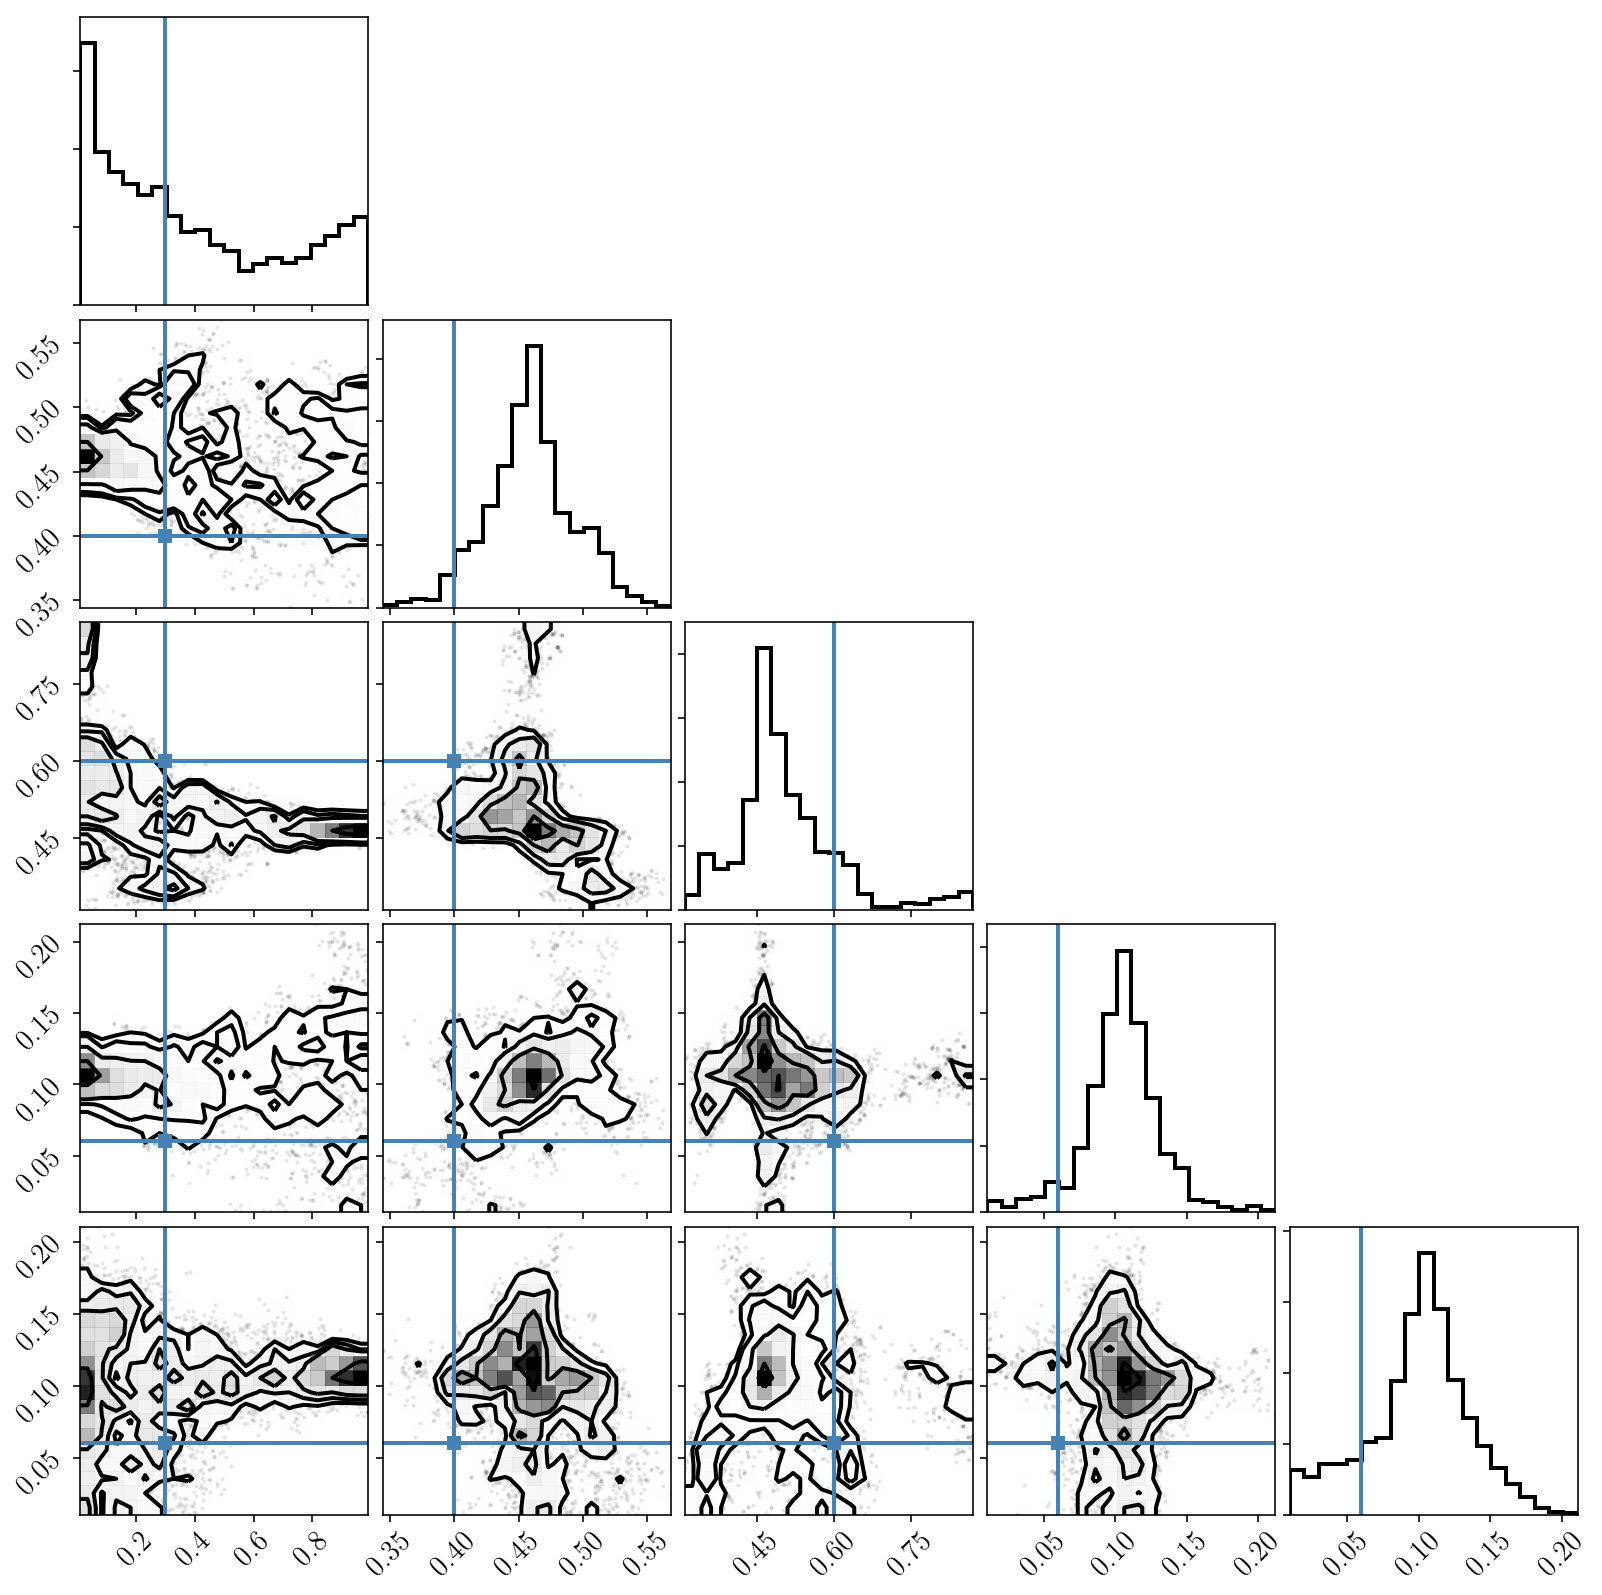

In [13]:
_ = corner.corner(param_samples_hyperonly, truths=params)

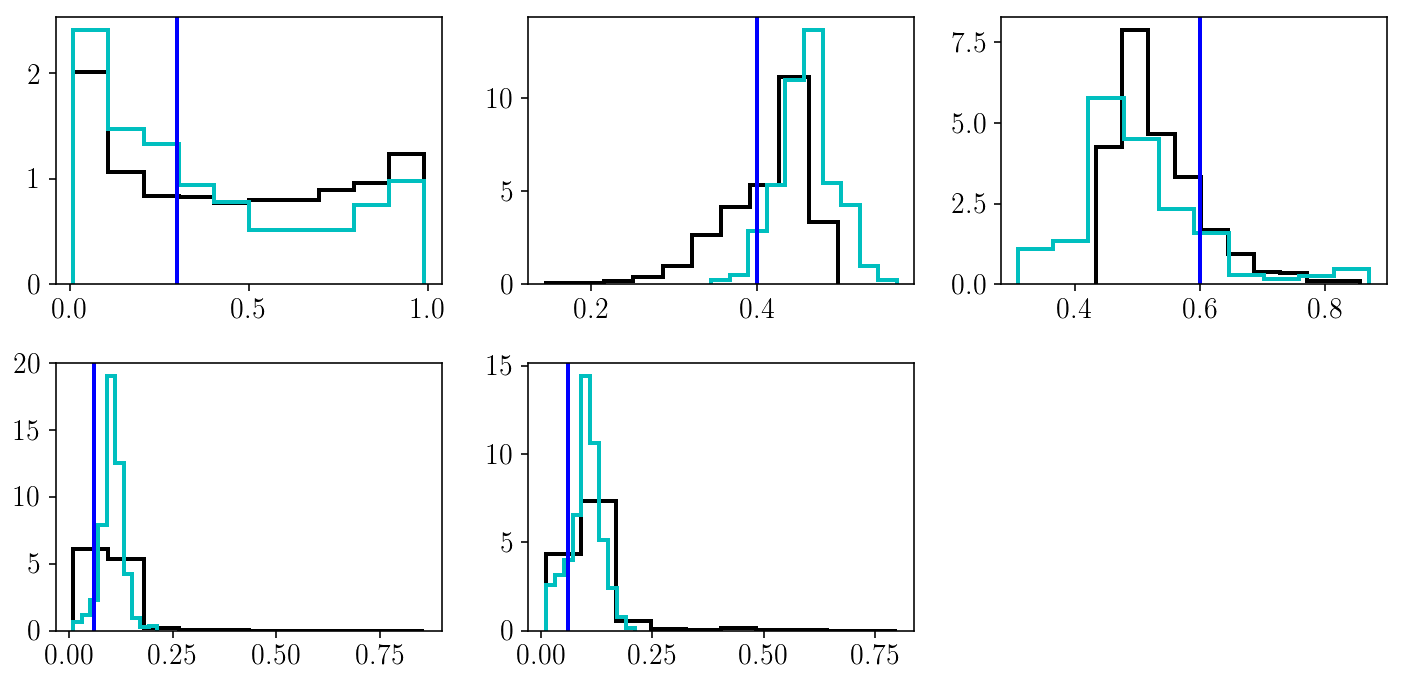

In [23]:
fig, axs = plt.subplots(2, 3, figsize=(10, 5))
axs = axs.ravel()
for i in range(5):
    axs[i].hist(sampler.flatchain[:, i], histtype='step', normed=True)
    axs[i].hist(param_samples_hyperonly[:, i], histtype='step', normed=True)
    axs[i].axvline(params[i], c='b')
plt.delaxes(axs[-1])
fig.tight_layout()

In [15]:
def sublnprob_withxis(params):
    alphas, betas, gammas = params[0:nt], params[nt:2*nt], params[2*nt:3*nt]
    xis = params[3*nt:3*nt+nobj]
    lnlikes = np.log(alphas[None, :]) + lngaussian(xis[:, None], betas[None, :], gammas[None, :]) + \
        lngaussian(yis[:, None], xis[:, None], sigmais[:, None])
    res = - np.sum(logsumexp(lnlikes, axis=1))
    if ~np.isfinite(res):
        print("Infinite likelihood call with", params)
    return res

def lnprob_withxis(params):
    zs, betas, gammas = params[0:nt-1], params[nt-1:2*nt-1], params[2*nt-1:3*nt-1]
    alphas = zs_to_alphas(zs)
    res = sublnprob_withxis(np.concatenate([alphas, params[nt-1:]]))
    return res

sublnprob_withxis_grad = grad(sublnprob_withxis)
sublnprob_withxis_hessian = hessian(sublnprob_withxis)

def lnprob_withxis_grad(params):
    zs, betas, gammas = params[0:nt-1], params[nt-1:2*nt-1], params[2*nt-1:3*nt-1]
    alphas = zs_to_alphas(zs)
    jac = alphaszs_jacobian(alphas, zs)
    subgrads = sublnprob_withxis_grad(np.concatenate([alphas, params[nt-1:]]))
    grads = 1*subgrads[1:]
    grads[0:nt-1] = np.dot(jac, subgrads[0:nt])
    if np.any(~np.isfinite(grads)):
        print("Infinite likelihood gradient call with", params)
    return grads


def lnprob_withxis_hessian(params):
    zs, betas, gammas = params[0:nt-1], params[nt-1:2*nt-1], params[2*nt-1:3*nt-1]
    alphas = zs_to_alphas(zs)
    jac = alphaszs_jacobian(alphas, zs)
    subhess = sublnprob_withxis_hessian(np.concatenate([alphas, params[nt-1:]]))
    subhessdiag = np.diag(subhess)
    hess = 1*subhessdiag[1:]
    hess[0:nt-1] = np.diag(np.dot(np.dot(jac, subhess[0:nt, 0:nt]), jac.T))
    if np.any(~np.isfinite(hess)):
        print("Infinite likelihood hessian call with", params)
    return hess

params = np.concatenate([zs, betas, gammas, xis])
print(lnprob_withxis(params), lnprob_withxis_grad(params), lnprob_withxis_hessian(params))

def fun(params):
    return lnprob_withxis(params)
def fun_grad(params):
    return lnprob_withxis_grad(params)

relative_accuracy = 0.001
#test_derivative(params, fun, fun_grad, relative_accuracy, superverbose=False)

def fun_hess(params):
    return lnprob_withxis_hessian(params)

relative_accuracy = 0.001
test_derivative(params, fun, fun_hess, relative_accuracy, superverbose=False, n=2)

-373.087464474 [ -1.76028772e+01   2.43954052e+02  -3.76981636e+01  -1.84077235e+02
  -1.14203729e+01   8.41945827e+00  -9.84839122e+00   3.20713063e+00
  -9.05303334e+00  -1.50290001e+01   3.23593033e+00   1.34665475e+01
   1.78656347e+01  -1.36872803e+01  -1.31403876e+01   1.25902272e+01
  -7.63622058e+00  -2.08362928e+01  -1.41112966e+01   8.64220974e+00
   2.45659716e+01   1.37564461e+01  -4.10946694e+01  -8.27875727e+00
   2.19618645e+00  -6.11826446e+00  -2.68569987e+01  -1.33654720e+01
   4.40429365e+00  -9.15565642e+00  -1.91804699e+01  -2.64031222e+01
   5.25636425e+00   5.88197139e+00   1.04123888e+01  -1.15418989e+01
  -1.70646657e+01   3.77927175e+00  -1.57814962e+01  -5.08714430e+00
  -3.44835238e+01   1.65058612e+01   5.27742007e+00  -4.59353758e+01
   5.61219275e+00   6.40620206e+00   1.41891749e+01   6.46572252e+00
  -8.47711147e+00  -1.20791517e+00  -6.53978938e+00   6.73987013e+00
  -6.43123007e+00  -2.23048192e+01   8.63430788e+00  -9.66577183e+00
  -2.05527031e+00  

In [16]:
num_samples, burnin = 7000, 2000

params = np.concatenate([zs, betas, gammas, xis])
bounds = np.zeros((params.size, 2))
bounds[:, 0] = 0.01
bounds[:, 1] = 0.99
param_samples_withxis = np.zeros((num_samples, params.size))
param_samples_withxis[0, :] = params 

hess = np.abs(lnprob_withxis_hessian(params))
for i in range(1, num_samples):
    print(i, end=" ")
    step_size = 10.**np.random.uniform(-3, -1)
    num_steps = np.random.randint(5, 20)
    if i % 500 == 0:
        newparams = np.mean(param_samples_withxis[0:i-1, :], axis=0)
        hess = np.abs(lnprob_withxis_hessian(newparams))
    param_samples_withxis[i, :] =\
        hmc_sampler(param_samples_withxis[i-1, :],
                    lnprob_withxis, lnprob_withxis_grad,
                    step_size, num_steps,
                    bounds=bounds, inv_mass_matrix_diag=1./hess)
param_samples_withxis = param_samples_withxis[burnin:, :]

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 

1862 1863 1864 1865 1866 1867 1868 1869 1870 1871 1872 1873 1874 1875 1876 1877 1878 1879 1880 1881 1882 1883 1884 1885 1886 1887 1888 1889 1890 1891 1892 1893 1894 1895 1896 1897 1898 1899 1900 1901 1902 1903 1904 1905 1906 1907 1908 1909 1910 1911 1912 1913 1914 1915 1916 1917 1918 1919 1920 1921 1922 1923 1924 1925 1926 1927 1928 1929 1930 1931 1932 1933 1934 1935 1936 1937 1938 1939 1940 1941 1942 1943 1944 1945 1946 1947 1948 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 

3501 3502 3503 3504 3505 3506 3507 3508 3509 3510 3511 3512 3513 3514 3515 3516 3517 3518 3519 3520 3521 3522 3523 3524 3525 3526 3527 3528 3529 3530 3531 3532 3533 3534 3535 3536 3537 3538 3539 3540 3541 3542 3543 3544 3545 3546 3547 3548 3549 3550 3551 3552 3553 3554 3555 3556 3557 3558 3559 3560 3561 3562 3563 3564 3565 3566 3567 3568 3569 3570 3571 3572 3573 3574 3575 3576 3577 3578 3579 3580 3581 3582 3583 3584 3585 3586 3587 3588 3589 3590 3591 3592 3593 3594 3595 3596 3597 3598 3599 3600 3601 3602 3603 3604 3605 3606 3607 3608 3609 3610 3611 3612 3613 3614 3615 3616 3617 3618 3619 3620 3621 3622 3623 3624 3625 3626 3627 3628 3629 3630 3631 3632 3633 3634 3635 3636 3637 3638 3639 3640 3641 3642 3643 3644 3645 3646 3647 3648 3649 3650 3651 3652 3653 3654 3655 3656 3657 3658 3659 3660 3661 3662 3663 3664 3665 3666 3667 3668 3669 3670 3671 3672 3673 3674 3675 3676 3677 3678 3679 3680 3681 3682 3683 3684 3685 3686 3687 3688 3689 3690 3691 3692 3693 3694 3695 3696 3697 3698 3699 3700 

5145 5146 5147 5148 5149 5150 5151 5152 5153 5154 5155 5156 5157 5158 5159 5160 5161 5162 5163 5164 5165 5166 5167 5168 5169 5170 5171 5172 5173 5174 5175 5176 5177 5178 5179 5180 5181 5182 5183 5184 5185 5186 5187 5188 5189 5190 5191 5192 5193 5194 5195 5196 5197 5198 5199 5200 5201 5202 5203 5204 5205 5206 5207 5208 5209 5210 5211 5212 5213 5214 5215 5216 5217 5218 5219 5220 5221 5222 5223 5224 5225 5226 5227 5228 5229 5230 5231 5232 5233 5234 5235 5236 5237 5238 5239 5240 5241 5242 5243 5244 5245 5246 5247 5248 5249 5250 5251 5252 5253 5254 5255 5256 5257 5258 5259 5260 5261 5262 5263 5264 5265 5266 5267 5268 5269 5270 5271 5272 5273 5274 5275 5276 5277 5278 5279 5280 5281 5282 5283 5284 5285 5286 5287 5288 5289 5290 5291 5292 5293 5294 5295 5296 5297 5298 5299 5300 5301 5302 5303 5304 5305 5306 5307 5308 5309 5310 5311 5312 5313 5314 5315 5316 5317 5318 5319 5320 5321 5322 5323 5324 5325 5326 5327 5328 5329 5330 5331 5332 5333 5334 5335 5336 5337 5338 5339 5340 5341 5342 5343 5344 

6786 6787 6788 6789 6790 6791 6792 6793 6794 6795 6796 6797 6798 6799 6800 6801 6802 6803 6804 6805 6806 6807 6808 6809 6810 6811 6812 6813 6814 6815 6816 6817 6818 6819 6820 6821 6822 6823 6824 6825 6826 6827 6828 6829 6830 6831 6832 6833 6834 6835 6836 6837 6838 6839 6840 6841 6842 6843 6844 6845 6846 6847 6848 6849 6850 6851 6852 6853 6854 6855 6856 6857 6858 6859 6860 6861 6862 6863 6864 6865 6866 6867 6868 6869 6870 6871 6872 6873 6874 6875 6876 6877 6878 6879 6880 6881 6882 6883 6884 6885 6886 6887 6888 6889 6890 6891 6892 6893 6894 6895 6896 6897 6898 6899 6900 6901 6902 6903 6904 6905 6906 6907 6908 6909 6910 6911 6912 6913 6914 6915 6916 6917 6918 6919 6920 6921 6922 6923 6924 6925 6926 6927 6928 6929 6930 6931 6932 6933 6934 6935 6936 6937 6938 6939 6940 6941 6942 6943 6944 6945 6946 6947 6948 6949 6950 6951 6952 6953 6954 6955 6956 6957 6958 6959 6960 6961 6962 6963 6964 6965 6966 6967 6968 6969 6970 6971 6972 6973 6974 6975 6976 6977 6978 6979 6980 6981 6982 6983 6984 6985 

IndexError: index 5 is out of bounds for axis 0 with size 5

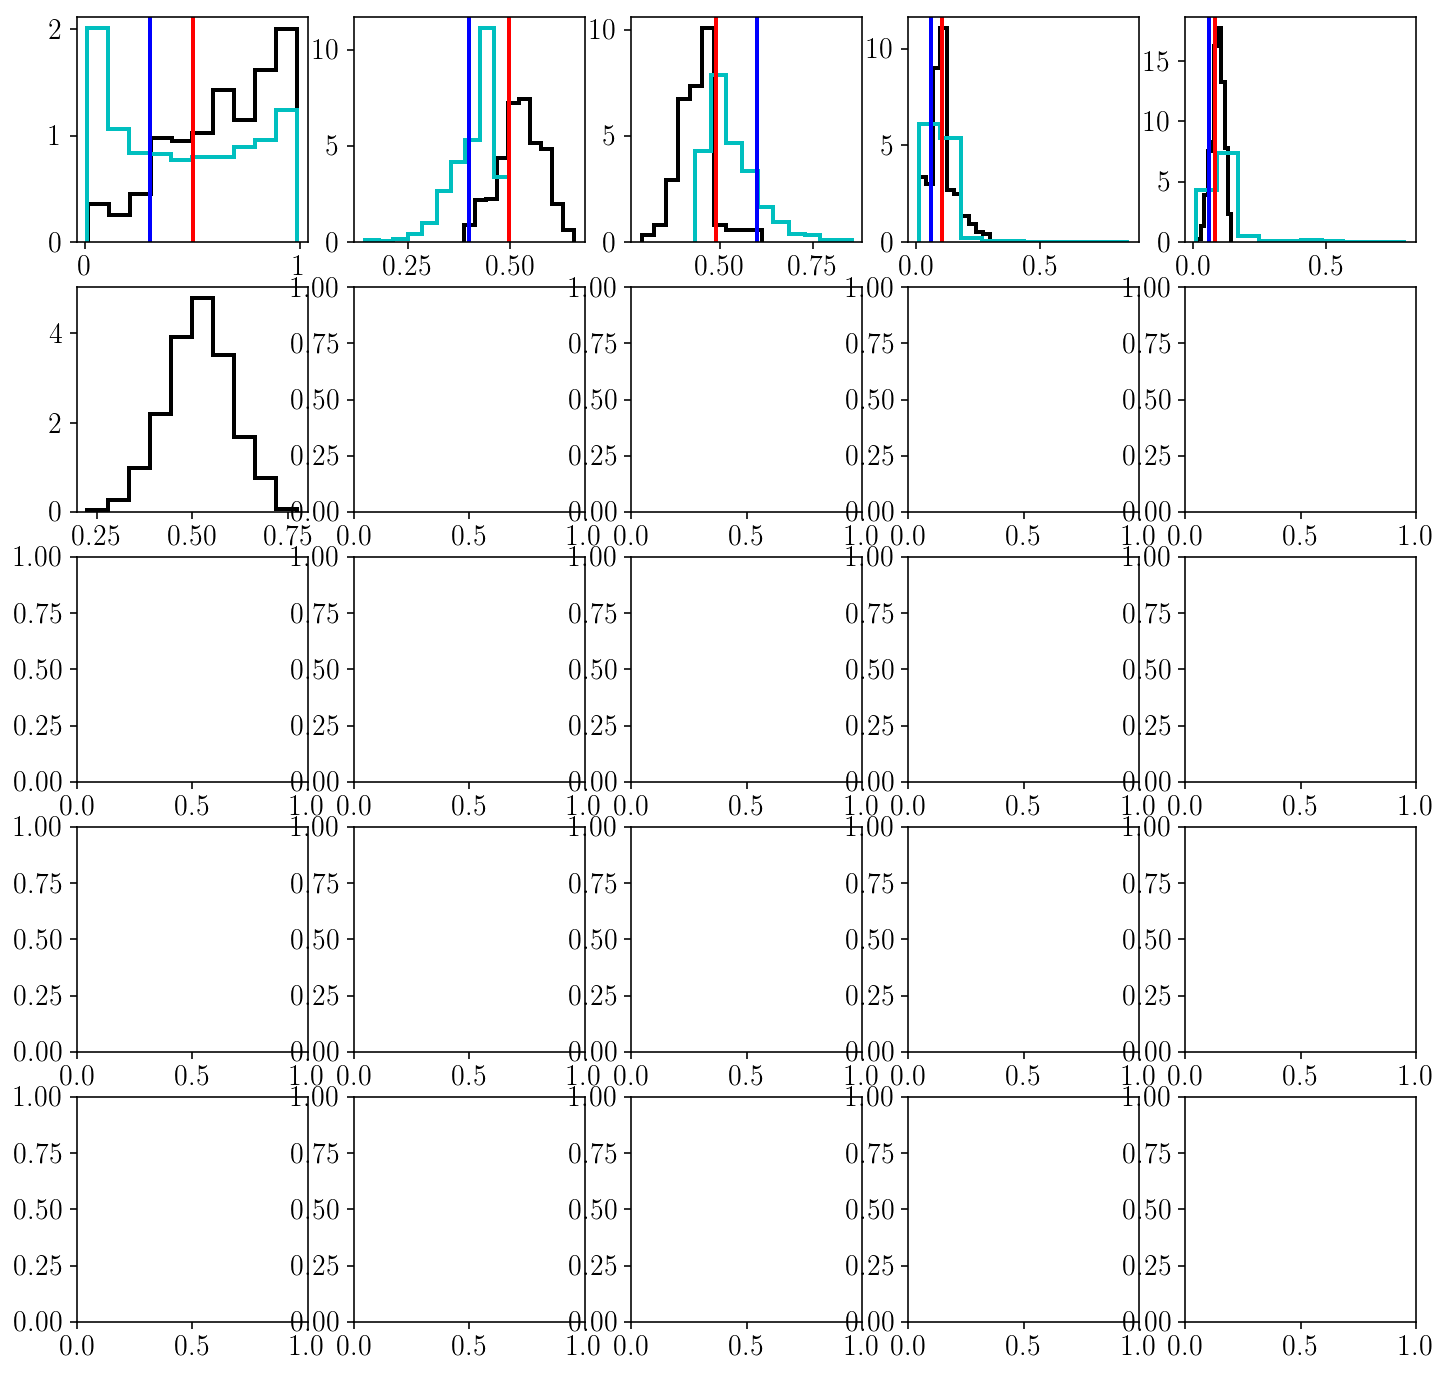

In [24]:
fig, axs = plt.subplots(5, 5, figsize=(12, 12))
axs = axs.ravel()
for i in range(axs.size):
    axs[i].hist(param_samples_withxis[:, i], histtype='step', normed=True)
    if i < 5:
        axs[i].hist(sampler.flatchain[:, i], histtype='step', normed=True)    
    axs[i].axvline(params[i], c='b')
    axs[i].axvline(newparams[i], c='r')
    if i > 5:
        likedraws = yis[i-5] + np.random.randn(param_samples_withxis[:, i].size) * sigmais[i-5]
        axs[i].hist(likedraws, histtype='step', normed=True, color='red')
fig.tight_layout()

In [18]:
mean1 = np.mean(sampler.flatchain[:, :], axis=0)
mean2 = np.mean(param_samples_withxis[:, :5], axis=0)
dmean = np.abs(mean1-mean2)
std1 = np.std(sampler.flatchain[:, :], axis=0)
std2 = np.std(param_samples_withxis[:, :5], axis=0)
print(mean1)
print(mean2)
print(dmean)
print(std1)
print(std2)
print(dmean/std1)
print(dmean/std2)

[ 0.98065942  0.54518901  0.55269024  0.35697292  0.06599277]
[ 0.64195716  0.52638914  0.43789941  0.1066978   0.09224507]
[ 0.33870225  0.01879987  0.11479083  0.25027513  0.0262523 ]
[ 0.00867258  0.01751151  0.0155313   0.01811408  0.0156878 ]
[ 0.24899733  0.05397812  0.04888116  0.05315421  0.02311499]
[ 39.05437479   1.07357162   7.39093645  13.81660444   1.67342173]
[ 1.36026462  0.34828675  2.34836573  4.708472    1.13572607]


Comments
- unimodal since well separated features
- what if the kernels overlap?
- model selection?

Not discussed here.
Pointers to solutions:
-

# Model 2: regression with multiple populations

fit two lines through data points

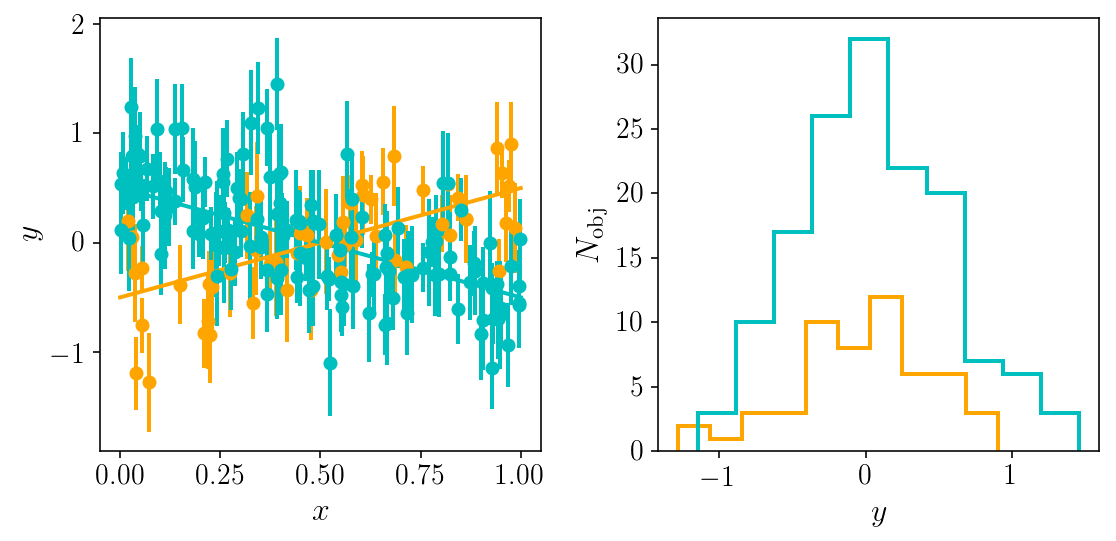

In [103]:
# This is a function to convert N-1 variables in [0, 1] onto the simplex,
# i.e. N variables that are positive and sum to one.
# This follows Betancourt (2010) https://arxiv.org/abs/1010.3436
# and we will discuss this reparametrization extensively below.
# At this stage, please ignore, ans assume that we are simply drawing
# the relative amplitudes of the mixture components.
nobj = 200 
nt = 2
zs = np.array([0.7])
alphas = zs_to_alphas(zs)
betas = np.array([0.5, -0.5])
betas.sort()
gammas = np.array([1, -1])
typecounts = np.random.multinomial(nobj, alphas)
types = np.concatenate([np.repeat(i, ni) for i, ni in enumerate(typecounts)]).astype(int)
xis = np.random.uniform(0, 1, nobj) # Gaussian draws
yis_true = np.array([betas[t] + gammas[t] * xi for t, xi in zip(types, xis)]) # Gaussian draws 
sigmais = np.random.uniform(0.2, 0.5, size=nobj) 
yis = yis_true + sigmais * np.random.randn(nobj)  # Gaussian draws from N(x_i, sigma_i)
x_grid = np.linspace(0, 1, 100)
p_x_grid = betas[None, :] + x_grid[:, None]*gammas[None, :]
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
colors = ['orange', 'c', 'green']
for t in range(nt):
    axs[0].plot(x_grid, x_grid*gammas[t] + betas[t], c=colors[t])
    ind = types == t
    axs[0].errorbar(xis[ind], yis[ind], sigmais[ind], fmt="o", c=colors[t])
    axs[1].hist(yis[ind], histtype='step', color=colors[t])
    axs[0].set_xlabel('$x$')
    axs[0].set_ylabel('$y$')
    axs[1].set_ylabel('$N_\mathrm{obj}$')
    axs[1].set_xlabel('$y$')
fig.tight_layout()

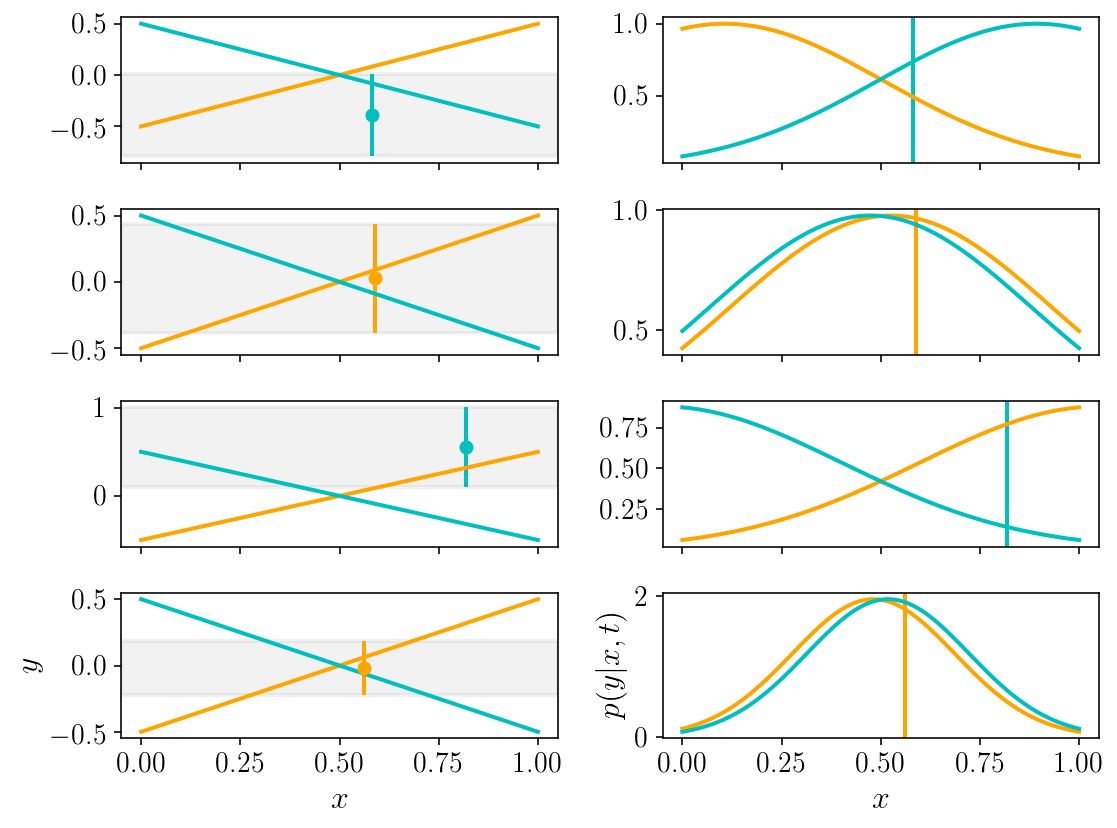

In [104]:
fig, axs = plt.subplots(4, 2, figsize=(8, 6), sharex=True, sharey=False)
colors = ['orange', 'c', 'green']
for i, sel in enumerate(np.random.choice(nobj, axs.shape[0], replace=False)):
    t = types[sel]
    axs[i, 0].axhspan(yis[sel]-sigmais[sel], yis[sel]+sigmais[sel], color="Gray", alpha=0.1)
    axs[i, 0].errorbar(xis[sel], yis[sel], sigmais[sel], fmt="o", c=colors[t])
    axs[i, 1].axvline(xis[sel], c=colors[t])
    for t in range(nt):
        axs[i, 0].plot(x_grid, x_grid*gammas[t] + betas[t], c=colors[t])
        y_grid = gaussian(x_grid*gammas[t] + betas[t], yis[sel], sigmais[sel])
        axs[i, 1].plot(x_grid, y_grid, c=colors[t])
axs[-1, 0].set_ylabel('$y$')
axs[-1, 0].set_xlabel('$x$')
axs[-1, 1].set_xlabel('$x$')
axs[-1, 1].set_ylabel('$p(y|x,t)$')
fig.tight_layout()

In [107]:
def sublnprob_withxis(params):
    alphas, betas, gammas = params[0:nt], params[nt:2*nt], params[2*nt:3*nt]
    xis = params[3*nt:3*nt+nobj]
    lnlikes = np.log(alphas[None, :]) + \
        lngaussian(yis[:, None],
                   xis[:, None] * gammas[None, :] + betas[None, :],
                   sigmais[:, None])
    res = - np.sum(logsumexp(lnlikes, axis=1))
    if ~np.isfinite(res):
        print("Infinite likelihood call with", params)
    return res

def lnprob_withxis(params):
    zs, betas, gammas = params[0:nt-1], params[nt-1:2*nt-1], params[2*nt-1:3*nt-1]
    alphas = zs_to_alphas(zs)
    res = sublnprob_withxis(np.concatenate([alphas, params[nt-1:]]))
    return res

sublnprob_withxis_grad = grad(sublnprob_withxis)
sublnprob_withxis_hessian = hessian(sublnprob_withxis)

def lnprob_withxis_grad(params):
    zs, betas, gammas = params[0:nt-1], params[nt-1:2*nt-1], params[2*nt-1:3*nt-1]
    alphas = zs_to_alphas(zs)
    jac = alphaszs_jacobian(alphas, zs)
    subgrads = sublnprob_withxis_grad(np.concatenate([alphas, params[nt-1:]]))
    grads = 1*subgrads[1:]
    grads[0:nt-1] = np.dot(jac, subgrads[0:nt])
    if np.any(~np.isfinite(grads)):
        print("Infinite likelihood gradient call with", params)
    return grads


def lnprob_withxis_hessian(params):
    zs, betas, gammas = params[0:nt-1], params[nt-1:2*nt-1], params[2*nt-1:3*nt-1]
    alphas = zs_to_alphas(zs)
    jac = alphaszs_jacobian(alphas, zs)
    subhess = sublnprob_withxis_hessian(np.concatenate([alphas, params[nt-1:]]))
    subhessdiag = np.diag(subhess)
    hess = 1*subhessdiag[1:]
    hess[0:nt-1] = np.diag(np.dot(np.dot(jac, subhess[0:nt, 0:nt]), jac.T))
    if np.any(~np.isfinite(hess)):
        print("Infinite likelihood hessian call with", params)
    return hess

params = np.concatenate([zs, betas, gammas, xis])

def fun(params):
    return lnprob_withxis(params)
def fun_grad(params):
    return lnprob_withxis_grad(params)

relative_accuracy = 0.001
test_derivative(params, fun, fun_grad, relative_accuracy, superverbose=False)

def fun_hess(params):
    return lnprob_withxis_hessian(params)

relative_accuracy = 0.001
test_derivative(params, fun, fun_hess, relative_accuracy, superverbose=False, n=2)

In [111]:
num_samples, burnin = 4000, 1000

params = np.concatenate([zs, betas, gammas, xis])
bounds = np.zeros((params.size, 2))
bounds[:, 0] = 0.0
bounds[:, 1] = 1.0
bounds[:3*nt-1, 0] = -1.0
param_samples_withxis = np.zeros((num_samples, params.size))
param_samples_withxis[0, :] = params 

hess = np.abs(lnprob_withxis_hessian(params))
for i in range(1, num_samples):
    print(i, end=" ")
    step_size = 10.**np.random.uniform(-3, -1)
    num_steps = np.random.randint(5, 20)
    if i % 500 == 0:
        newparams = np.mean(param_samples_withxis[0:i-1, :], axis=0)
        hess = np.abs(lnprob_withxis_hessian(newparams))
    param_samples_withxis[i, :] =\
        hmc_sampler(param_samples_withxis[i-1, :],
                    lnprob_withxis, lnprob_withxis_grad,
                    step_size, num_steps,
                    bounds=bounds, inv_mass_matrix_diag=1./hess)
param_samples_withxis = param_samples_withxis[burnin:, :]

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 

1580 1581 1582 1583 1584 1585 1586 1587 1588 1589 1590 1591 1592 1593 1594 1595 1596 1597 Error: could not confine samples within bounds!
Number of problematic parameters: 1 out of 205
1598 1599 1600 1601 1602 1603 1604 1605 1606 1607 1608 1609 1610 1611 Error: could not confine samples within bounds!
Number of problematic parameters: 1 out of 205
1612 1613 1614 1615 Error: could not confine samples within bounds!
Number of problematic parameters: 1 out of 205
1616 1617 1618 1619 1620 1621 1622 1623 1624 1625 1626 1627 1628 1629 1630 1631 1632 1633 1634 1635 Error: could not confine samples within bounds!
Number of problematic parameters: 1 out of 205
1636 1637 1638 1639 1640 Error: could not confine samples within bounds!
Number of problematic parameters: 1 out of 205
1641 1642 Error: could not confine samples within bounds!
Number of problematic parameters: 1 out of 205
1643 1644 1645 1646 1647 1648 1649 1650 Error: could not confine samples within bounds!
Number of problematic param

2121 2122 2123 2124 2125 2126 2127 2128 2129 2130 2131 2132 2133 2134 2135 Error: could not confine samples within bounds!
Number of problematic parameters: 1 out of 205
2136 2137 2138 2139 2140 2141 2142 2143 2144 2145 2146 2147 2148 2149 2150 2151 2152 2153 2154 2155 2156 2157 2158 2159 Error: could not confine samples within bounds!
Number of problematic parameters: 1 out of 205
2160 2161 2162 2163 2164 2165 2166 2167 2168 2169 2170 2171 2172 2173 2174 2175 2176 2177 2178 Error: could not confine samples within bounds!
Number of problematic parameters: 1 out of 205
2179 2180 2181 2182 2183 Error: could not confine samples within bounds!
Number of problematic parameters: 1 out of 205
2184 2185 2186 Error: could not confine samples within bounds!
Number of problematic parameters: 1 out of 205
2187 2188 Error: could not confine samples within bounds!
Number of problematic parameters: 1 out of 205
2189 2190 2191 2192 2193 2194 2195 2196 2197 2198 2199 2200 2201 Error: could not confine 

2497 2498 2499 2500 2501 2502 2503 2504 2505 2506 2507 2508 2509 2510 2511 2512 2513 2514 2515 2516 2517 2518 2519 2520 2521 2522 2523 2524 2525 2526 2527 2528 2529 2530 2531 2532 2533 2534 2535 2536 2537 2538 2539 2540 2541 2542 2543 2544 2545 2546 2547 2548 2549 2550 2551 2552 2553 2554 2555 2556 2557 2558 2559 2560 2561 2562 2563 2564 2565 2566 2567 2568 2569 2570 2571 2572 2573 2574 2575 2576 2577 2578 2579 2580 2581 2582 2583 2584 2585 2586 2587 2588 2589 2590 2591 2592 2593 2594 2595 2596 2597 2598 2599 2600 2601 2602 2603 2604 2605 2606 2607 2608 2609 2610 2611 2612 2613 2614 2615 2616 2617 2618 2619 2620 2621 2622 2623 2624 2625 2626 2627 2628 2629 2630 2631 2632 2633 2634 2635 2636 2637 2638 2639 2640 2641 2642 2643 2644 2645 2646 2647 2648 2649 2650 2651 2652 2653 2654 2655 2656 2657 2658 2659 2660 2661 2662 2663 2664 2665 2666 2667 2668 2669 2670 2671 2672 2673 2674 2675 2676 2677 2678 2679 2680 2681 2682 2683 2684 2685 2686 2687 2688 2689 2690 2691 2692 2693 2694 2695 2696 

3795 3796 3797 3798 3799 3800 3801 3802 3803 3804 Error: could not confine samples within bounds!
Number of problematic parameters: 1 out of 205
3805 3806 3807 3808 Error: could not confine samples within bounds!
Number of problematic parameters: 1 out of 205
3809 3810 3811 3812 3813 3814 3815 3816 3817 3818 3819 3820 3821 3822 3823 3824 3825 3826 Error: could not confine samples within bounds!
Number of problematic parameters: 1 out of 205
3827 3828 3829 3830 3831 3832 3833 3834 3835 Error: could not confine samples within bounds!
Number of problematic parameters: 1 out of 205
3836 3837 3838 3839 3840 3841 3842 3843 Error: could not confine samples within bounds!
Number of problematic parameters: 1 out of 205
3844 3845 3846 3847 3848 3849 3850 3851 3852 3853 3854 3855 3856 3857 3858 3859 3860 3861 3862 3863 3864 3865 3866 3867 3868 3869 3870 3871 3872 3873 3874 3875 3876 3877 3878 3879 Error: could not confine samples within bounds!
Number of problematic parameters: 1 out of 205
3880 

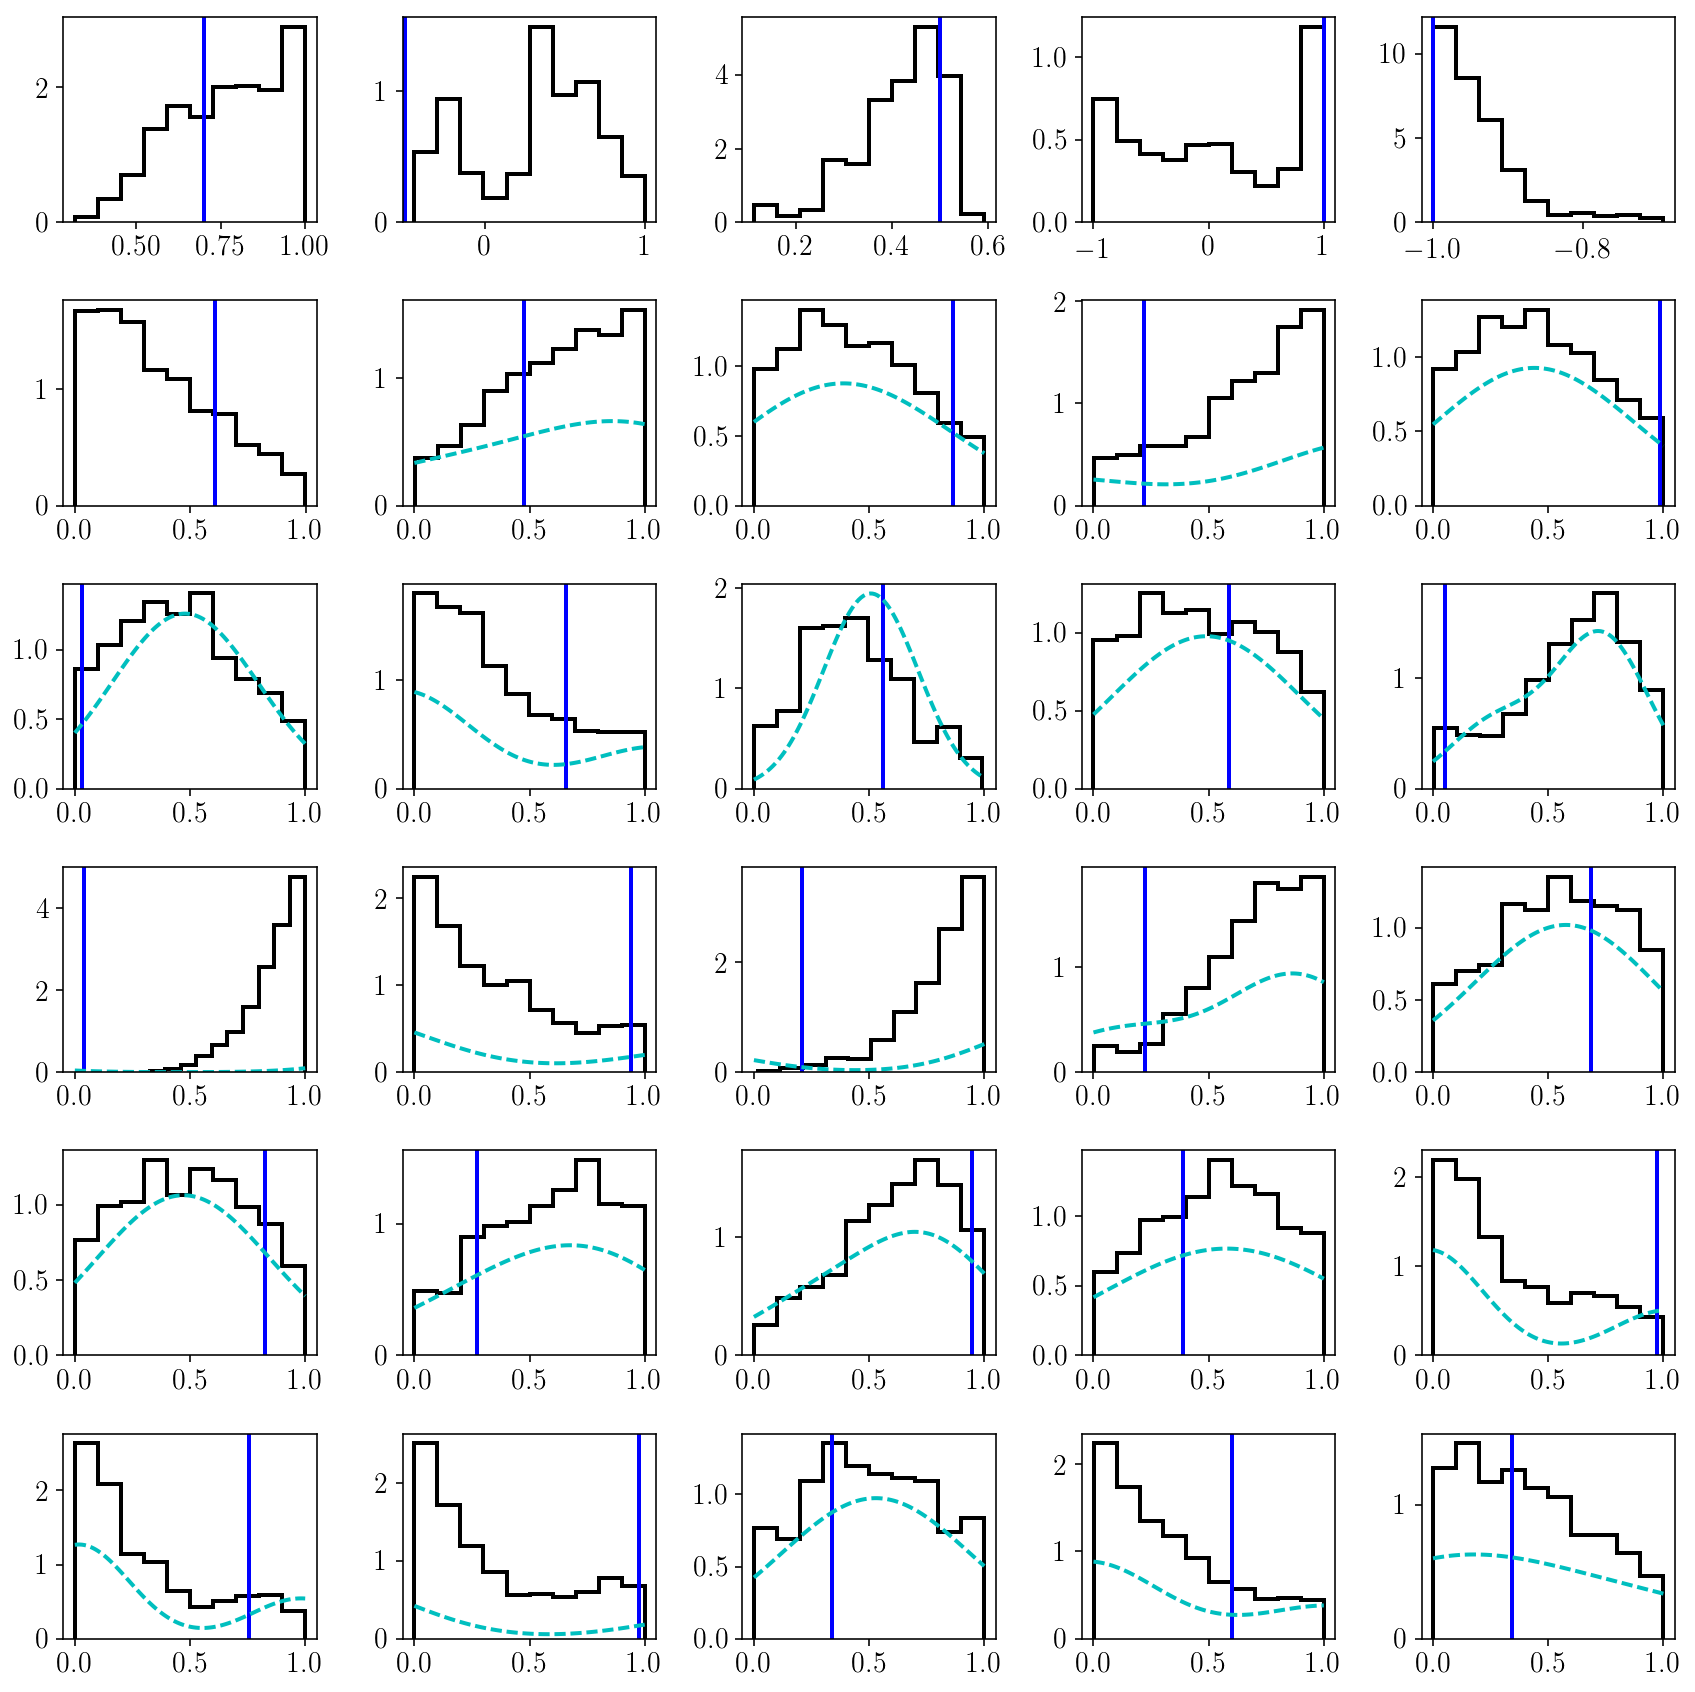

In [112]:
fig, axs = plt.subplots(6, 5, figsize=(12, 12))
axs = axs.ravel()
for i in range(axs.size):
    axs[i].hist(param_samples_withxis[:, i], histtype='step', normed=True)    
    axs[i].axvline(params[i], c='b')
    if i > 5:
        y_grid = alphas[None, :]*gaussian(x_grid[:, None]*gammas[None, :] + betas[None, :], yis[i-5], sigmais[i-5])
        axs[i].plot(x_grid, y_grid.sum(axis=1), ls='dashed')
fig.tight_layout()

In [113]:
def lnprob_xis_onetype(xis, t=t, hyperparams=hyperparams):
    zs, betas, gammas = hyperparams[0:nt-1], hyperparams[nt-1:2*nt-1], hyperparams[2*nt-1:3*nt-1]
    alphas = zs_to_alphas(zs)
    lnlikes = np.log(alphas[t]) + \
        lngaussian(yis, xis * gammas[t] + betas[t], sigmais)
    res = - np.sum(lnlikes)
    if ~np.isfinite(res):
        print("Infinite likelihood call with", params)
    return res

lnprob_xis_onetype_grad = grad(lnprob_xis_onetype)
lnprob_xis_onetype_hessian_full = hessian(lnprob_xis_onetype)
def lnprob_xis_onetype_hessian(xis, **kwargs):
    return np.diag(lnprob_xis_onetype_hessian_full(xis, **kwargs))

params = 1*xis
kwargs = {'t': 1, 'hyperparams': np.concatenate([zs, betas, gammas])}

def fun(params):
    return lnprob_xis_onetype(params, **kwargs)
def fun_grad(params):
    return lnprob_xis_onetype_grad(params, **kwargs)

relative_accuracy = 0.001
test_derivative(params, fun, fun_grad, relative_accuracy, superverbose=False)

def fun_hess(params):
    return lnprob_xis_onetype_hessian(params, **kwargs)

relative_accuracy = 0.001
test_derivative(params, fun, fun_hess, relative_accuracy, superverbose=False, n=2)

In [114]:
def sublnprob_xisfixed(params, xis=xis):
    alphas, betas, gammas = params[0:nt], params[nt:2*nt], params[2*nt:3*nt]
    lnlikes = np.log(alphas[None, :]) + \
        lngaussian(yis[:, None], xis[:, :] * gammas[None, :] + betas[None, :], sigmais[:, None])
    res = - np.sum(logsumexp(lnlikes, axis=1))
    if ~np.isfinite(res):
        print("Infinite likelihood call with", params)
    return res

def lnprob_xisfixed(params, xis=xis):
    zs, betas, gammas = params[0:nt-1], params[nt-1:2*nt-1], params[2*nt-1:3*nt-1]
    alphas = zs_to_alphas(zs)
    res = sublnprob_xisfixed(np.concatenate([alphas, params[nt-1:]]), xis=xis)
    return res

sublnprob_xisfixed_grad = grad(sublnprob_xisfixed)
sublnprob_xisfixed_hessian = hessian(sublnprob_xisfixed)

def lnprob_xisfixed_grad(params, xis=xis):
    zs, betas, gammas = params[0:nt-1], params[nt-1:2*nt-1], params[2*nt-1:3*nt-1]
    alphas = zs_to_alphas(zs)
    jac = alphaszs_jacobian(alphas, zs)
    subgrads = sublnprob_xisfixed_grad(np.concatenate([alphas, params[nt-1:]]), xis=xis)
    grads = 1*subgrads[1:]
    grads[0:nt-1] = np.dot(jac, subgrads[0:nt])
    if np.any(~np.isfinite(grads)):
        print("Infinite likelihood gradient call with", params)
    return grads


def lnprob_xisfixed_hessian(params, xis=xis):
    zs, betas, gammas = params[0:nt-1], params[nt-1:2*nt-1], params[2*nt-1:3*nt-1]
    alphas = zs_to_alphas(zs)
    jac = alphaszs_jacobian(alphas, zs)
    subhess = sublnprob_xisfixed_hessian(np.concatenate([alphas, params[nt-1:]]), xis=xis)
    subhessdiag = np.diag(subhess)
    hess = 1*subhessdiag[1:]
    hess[0:nt-1] = np.diag(np.dot(np.dot(jac, subhess[0:nt, 0:nt]), jac.T))
    if np.any(~np.isfinite(hess)):
        print("Infinite likelihood hessian call with", params)
    return hess

params = np.concatenate([zs, betas, gammas])
kwargs = {'xis': xis[:, None] * np.ones((1, nt))}

def fun(params):
    return lnprob_xisfixed(params, **kwargs)
def fun_grad(params):
    return lnprob_xisfixed_grad(params, **kwargs)

relative_accuracy = 0.001
test_derivative(params, fun, fun_grad, relative_accuracy, superverbose=False)

def fun_hess(params):
    return lnprob_xisfixed_hessian(params, **kwargs)

relative_accuracy = 0.001
test_derivative(params, fun, fun_hess, relative_accuracy, superverbose=False, n=2)

In [115]:
num_samples = 2000

hyperparams = np.concatenate([zs, betas, gammas])
hyperparams_samples = np.zeros((num_samples, hyperparams.size))
hyperparams_samples[0, :] = hyperparams
hyperparams_bounds = np.zeros((hyperparams.size, 2))
hyperparams_bounds[:, 0] = -1.0
hyperparams_bounds[:, 1] = 1.0

xits_samples = np.zeros((num_samples, xis.size, nt))
for t in range(nt):
    xits_samples[0, :, t] = xis 
xis_bounds = np.zeros((xis.size, 2))
xis_bounds[:, 0] = 0.0
xis_bounds[:, 1] = 1.0

for i in range(1, num_samples):
    print(i, end=" ")
    step_size = 10.**np.random.uniform(-3, -2)
    num_steps = np.random.randint(5, 20)
    
    kwargs = {'xis': xits_samples[i-1, :, :]}
    hyperparams_samples[i, :] =\
        hmc_sampler(hyperparams_samples[i-1, :],
                    lnprob_xisfixed, lnprob_xisfixed_grad,
                    step_size, num_steps,
                    bounds = hyperparams_bounds,
                    kwargs = kwargs)#, inv_mass_matrix_diag=1./hess)
    for t in range(nt):
        xits_samples[i, :, t] =\
            hmc_sampler(xits_samples[i-1, :, t],
                        lnprob_xis_onetype, lnprob_xis_onetype_grad,
                        step_size, num_steps,
                        bounds = xis_bounds,
                        kwargs = {'t': t, 'hyperparams': hyperparams_samples[i, :]})#, inv_mass_matrix_diag=1./hess)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 

1868 1869 1870 1871 1872 1873 1874 1875 1876 1877 1878 1879 1880 1881 1882 1883 1884 1885 1886 1887 1888 1889 1890 1891 1892 1893 1894 1895 1896 1897 1898 1899 1900 1901 1902 1903 1904 1905 1906 1907 1908 1909 1910 1911 1912 1913 1914 1915 1916 1917 1918 1919 1920 1921 1922 1923 1924 1925 1926 1927 1928 1929 1930 1931 1932 1933 1934 1935 1936 1937 1938 1939 1940 1941 1942 1943 1944 1945 1946 1947 1948 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 

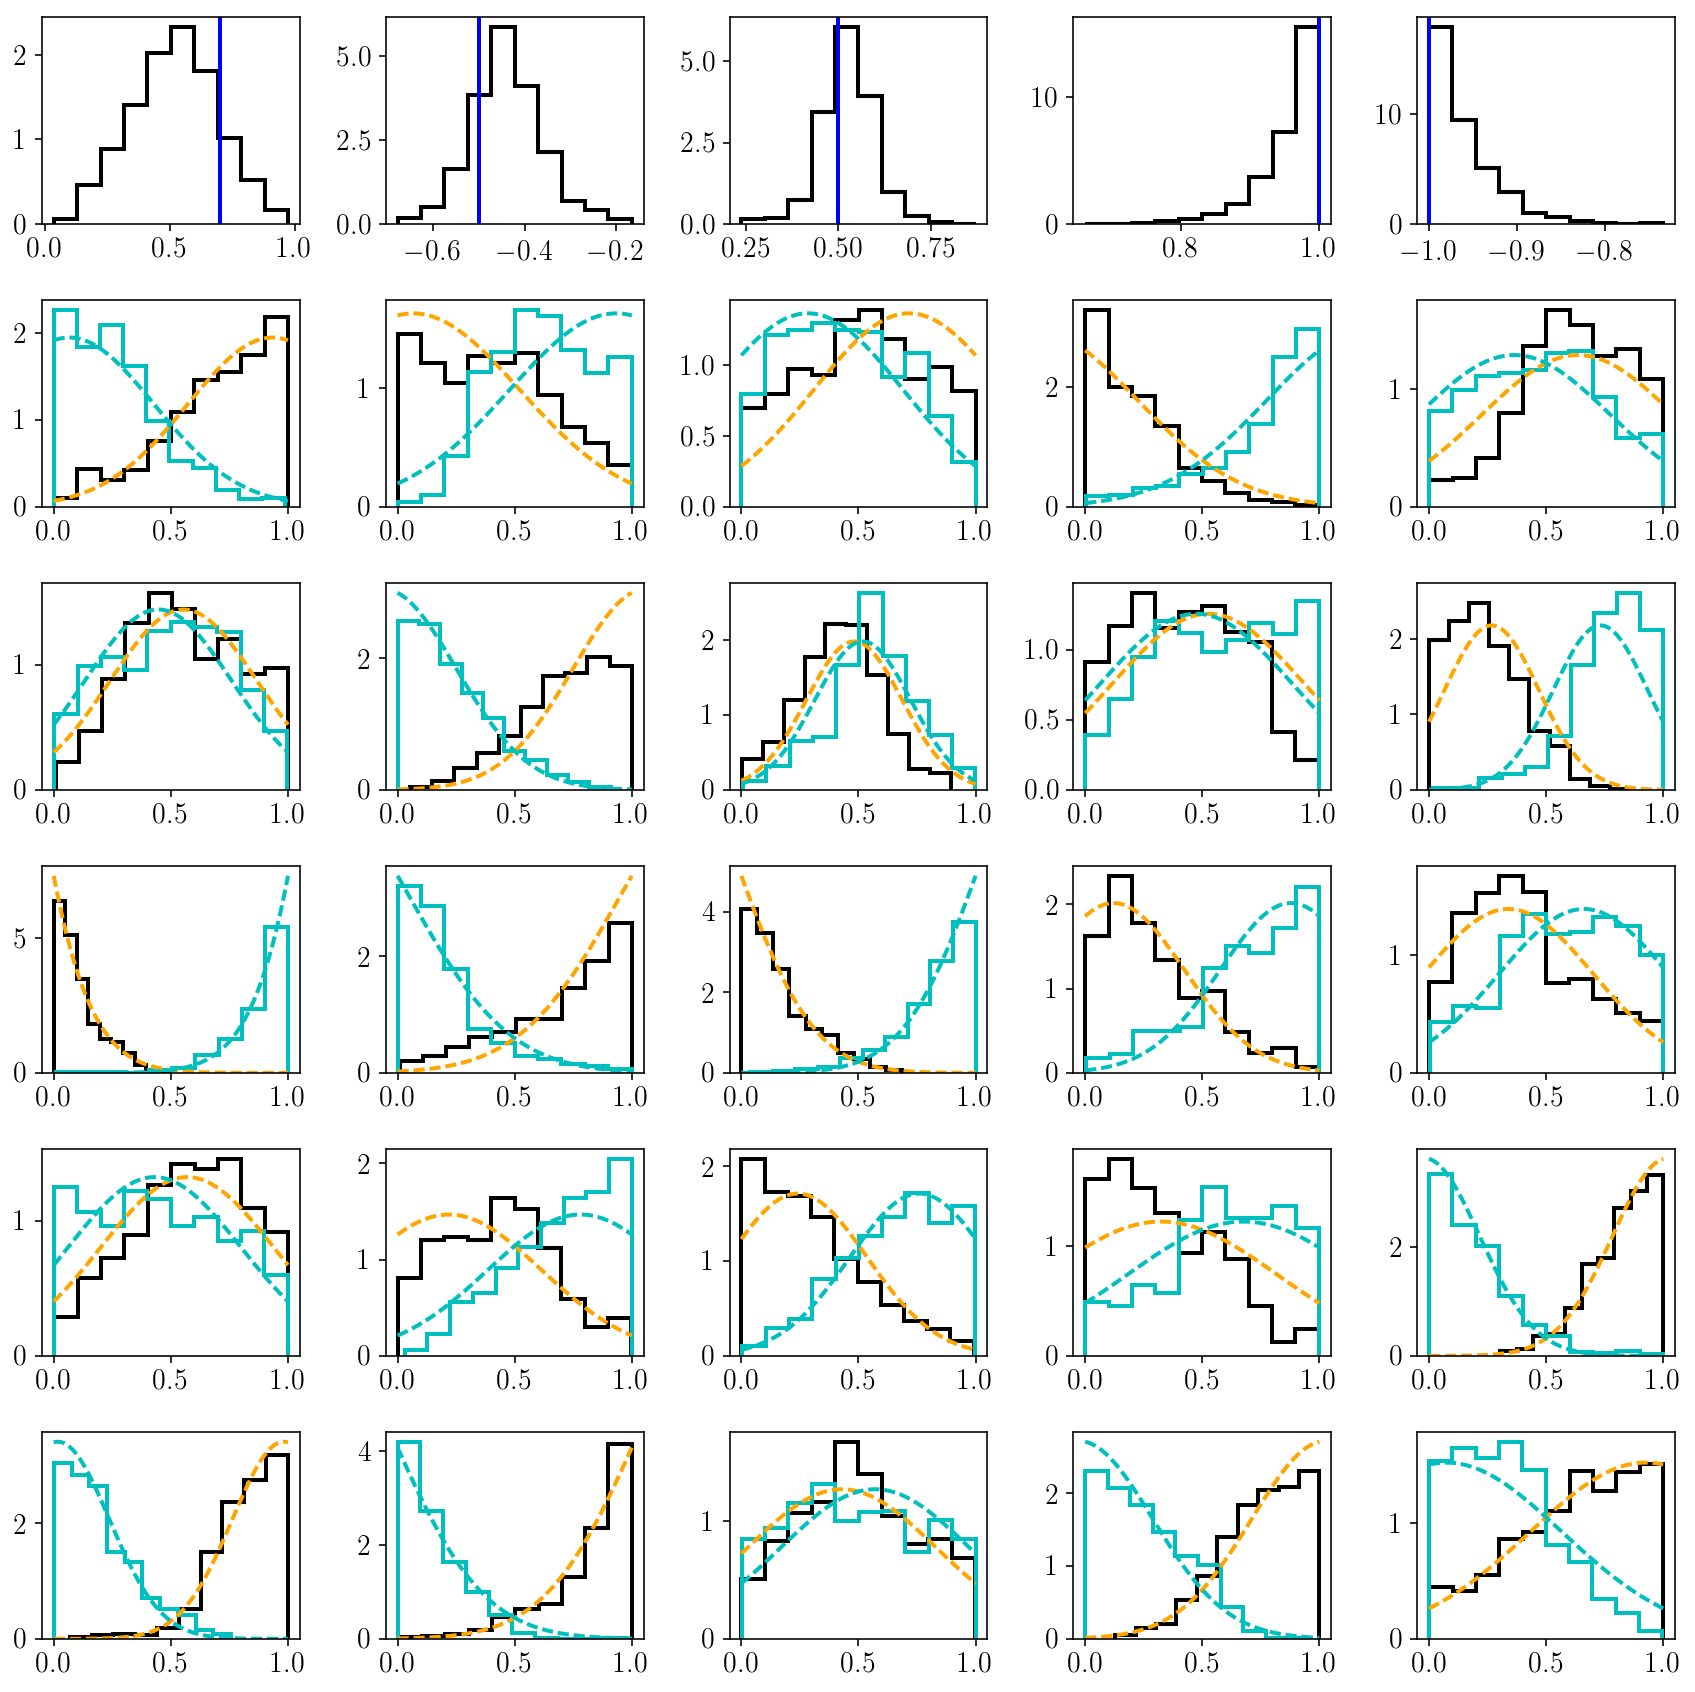

In [119]:
fig, axs = plt.subplots(6, 5, figsize=(12, 12))
axs = axs.ravel()
for i in range(axs.size):
    if i < 5:
        axs[i].hist(hyperparams_samples[:, i], histtype='step', normed=True)    
        axs[i].axvline(hyperparams[i], c='b')
    if i >= 5:
        for t in range(nt):
            y_grid = gaussian(x_grid*gammas[t] + betas[t], yis[i-5], sigmais[i-5])
            y_grid /= np.trapz(y_grid, x=x_grid)
            axs[i].plot(x_grid, y_grid, ls='dashed', color=colors[t])
            axs[i].hist(xits_samples[:, i-5, t], histtype='step', normed=True)    
fig.tight_layout()

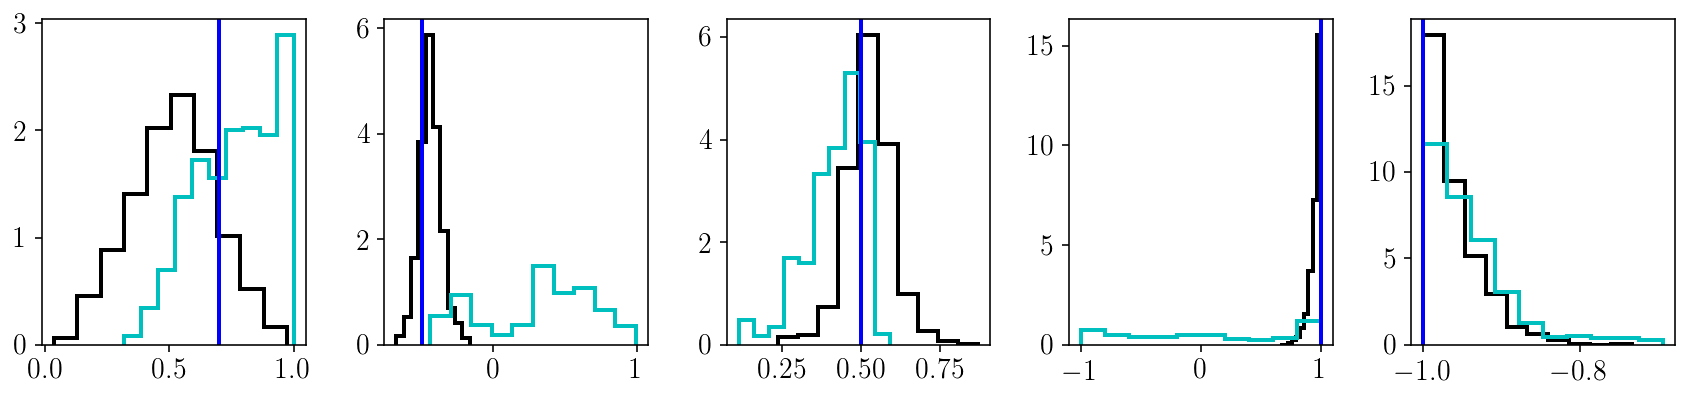

In [122]:
fig, axs = plt.subplots(1, 5, figsize=(12, 3))
axs = axs.ravel()
for i in range(axs.size):
    if i < 5:
        axs[i].hist(hyperparams_samples[:, i], histtype='step', normed=True)  
        axs[i].hist(param_samples_withxis[:, i], histtype='step', normed=True)   
        axs[i].axvline(hyperparams[i], c='b')   
fig.tight_layout()